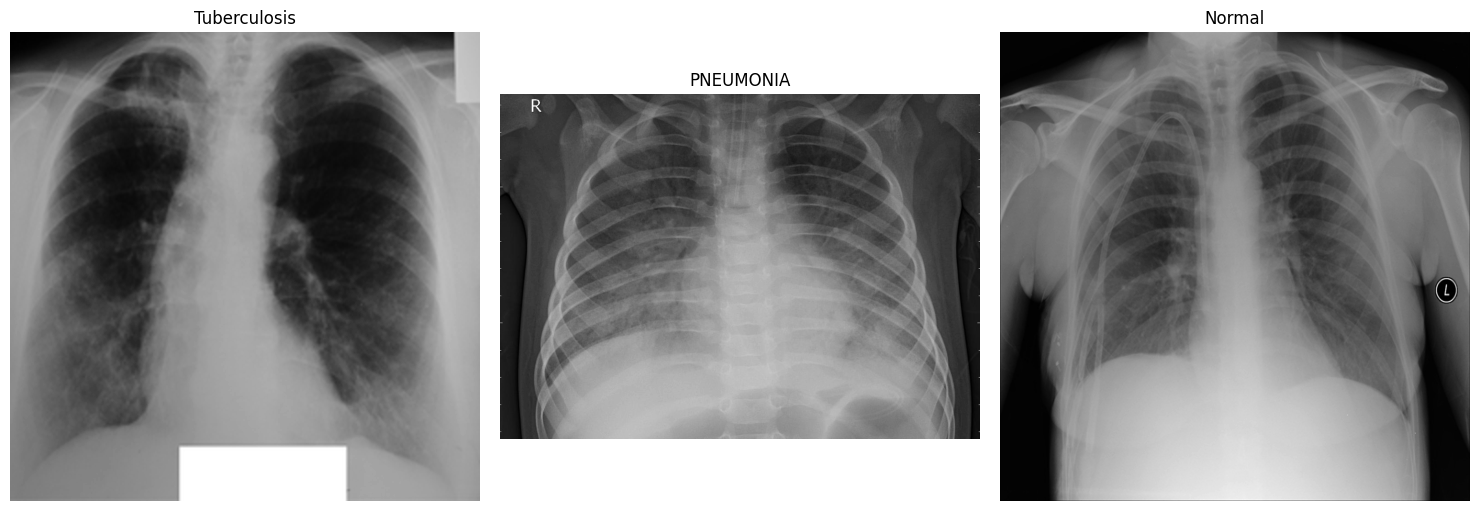

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Step 2: Define path to your dataset
base_path = 'ChestXrayProject/Dataset'

categories = ['Tuberculosis', 'PNEUMONIA', 'Normal']

# Step 3: Function to load and show an image
def show_sample_images(base_path, categories):
    plt.figure(figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        file_list = os.listdir(category_path)
        image_path = os.path.join(category_path, file_list[0])  # first image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, 3, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(base_path, categories)

Classes found: ['Normal', 'PNEUMONIA', 'Tuberculosis']

Image count per class:


,Number of Images
Normal,1500
PNEUMONIA,1000
Tuberculosis,700


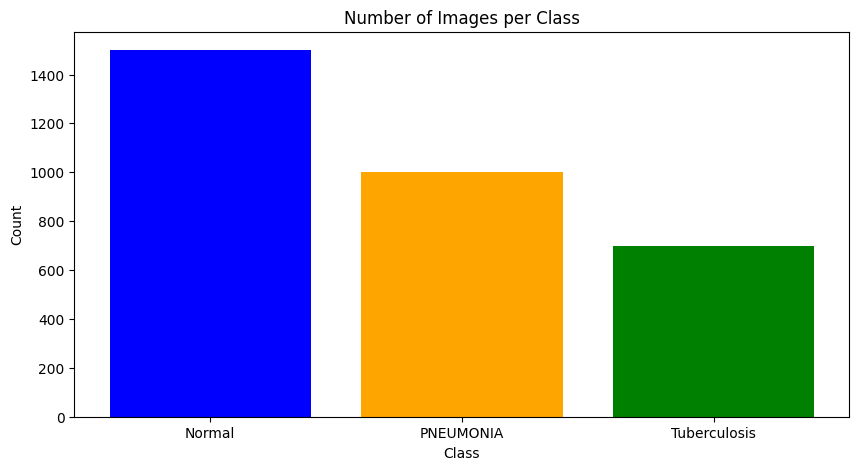


Sample files from each class:
Normal: ['Normal-1.png', 'Normal-10.png', 'Normal-100.png']
PNEUMONIA: ['person100_virus_184.jpeg', 'person101_virus_187.jpeg', 'person101_virus_188.jpeg']
Tuberculosis: ['Tuberculosis-1.png', 'Tuberculosis-10.png', 'Tuberculosis-100.png']


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define your dataset path
dataset_path = r"C:/Users/tuhin/ChestXrayProject/Dataset"

# Get the list of classes (subdirectories in your Dataset folder)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes found:", classes)

# Count number of images in each class
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = num_images

# Create a DataFrame for nice display
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Number of Images'])
print("\nImage count per class:")
display(df_counts)

# Visualize the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green'])
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Show sample file names (optional)
print("\nSample files from each class:")
for class_name, count in class_counts.items():
    class_path = os.path.join(dataset_path, class_name)
    sample_files = os.listdir(class_path)[:3]  # Show first 3 files
    print(f"{class_name}: {sample_files}")

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Setup
original_base_path = 'ChestXrayProject/Dataset'
preprocessed_base_path = 'ChestXrayProject/preprocess_dataset'
IMG_SIZE = 224
categories = ['Normal', 'PNEUMONIA', 'Tuberculosis']

# Create output directories
for category in categories:
    os.makedirs(os.path.join(preprocessed_base_path, category), exist_ok=True)

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 1. Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # 3. Noise Reduction
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # 4. Normalize to [0, 255] uint8
    normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    return normalized

# Run preprocessing
for category in categories:
    input_folder = os.path.join(original_base_path, category)
    output_folder = os.path.join(preprocessed_base_path, category)
    
    for filename in tqdm(os.listdir(input_folder), desc=f"Processing {category}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            processed_img = preprocess_image(img_path)

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, processed_img)


Processing Tuberculosis: 100%|███████████████████████████████████████████████████████| 700/700 [00:17<00:00, 39.23it/s]


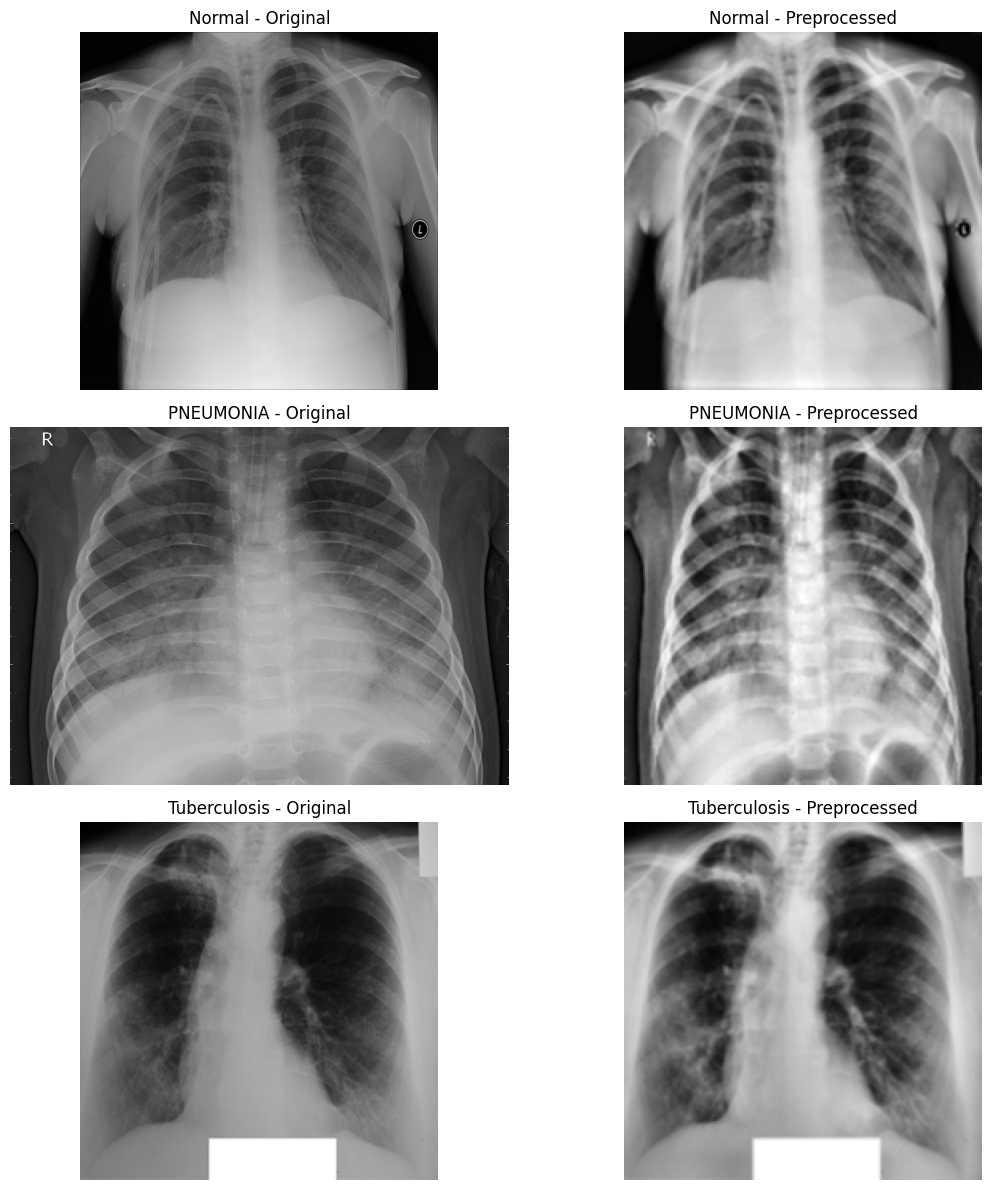

In [4]:
import matplotlib.pyplot as plt

def compare_before_after(original_base_path, preprocessed_base_path, categories):
    plt.figure(figsize=(12, len(categories) * 4))

    for idx, category in enumerate(categories):
        # Get first image file from category
        orig_folder = os.path.join(original_base_path, category)
        preproc_folder = os.path.join(preprocessed_base_path, category)
        
        # Find a sample image (same file name expected in both folders)
        sample_file = [f for f in os.listdir(orig_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][0]
        
        orig_path = os.path.join(orig_folder, sample_file)
        preproc_path = os.path.join(preproc_folder, sample_file)
        
        # Load images
        orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        preproc_img = cv2.imread(preproc_path, cv2.IMREAD_GRAYSCALE)

        # Show original
        plt.subplot(len(categories), 2, idx*2 + 1)
        plt.imshow(orig_img, cmap='gray')
        plt.title(f'{category} - Original')
        plt.axis('off')

        # Show preprocessed
        plt.subplot(len(categories), 2, idx*2 + 2)
        plt.imshow(preproc_img, cmap='gray')
        plt.title(f'{category} - Preprocessed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the comparison
compare_before_after(original_base_path, preprocessed_base_path, categories)


In [5]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

# Path setup
tb_folder = 'ChestXrayProject/preprocess_dataset/Tuberculosis'
augmented_count = 500  # Total new images to create
IMG_SIZE = 224

# Safe augmentation function
def safe_augment_image(img):
    rows, cols = img.shape

    # 1. Small rotation (-10° to 10°)
    angle = random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # 2. Brightness shift (±15 intensity units)
    brightness = random.randint(-15, 15)
    img = img.astype(np.int16)  # Prevent overflow
    img = np.clip(img + brightness, 0, 255).astype(np.uint8)

    # 3. Slight Gaussian noise
    if random.random() > 0.5:
        noise = np.random.normal(0, 5, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # 4. Very light translation (max 5 pixels)
    dx = random.randint(-5, 5)
    dy = random.randint(-5, 5)
    M_translate = np.float32([[1, 0, dx], [0, 1, dy]])
    img = cv2.warpAffine(img, M_translate, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    return img

# Collect existing TB images
tb_images = [f for f in os.listdir(tb_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Generate and save augmented images
save_index = 0
for i in tqdm(range(augmented_count), desc="Safely Augmenting Tuberculosis"):
    img_name = random.choice(tb_images)
    img_path = os.path.join(tb_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    aug_img = safe_augment_image(img)

    save_path = os.path.join(tb_folder, f'aug_tb_{save_index}.png')
    cv2.imwrite(save_path, aug_img)
    save_index += 1


Safely Augmenting Tuberculosis: 100%|████████████████████████████████████████████████| 500/500 [00:08<00:00, 61.67it/s]


In [6]:
import os
import shutil
import random
from tqdm import tqdm

# Paths
source_dir = 'ChestXrayProject/preprocess_dataset'
output_dir = 'ChestXrayProject/split_dataset'
categories = ['Normal', 'PNEUMONIA', 'Tuberculosis']

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Set random seed for reproducibility
random.seed(42)

# Create output directory structure
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split and copy files
for category in categories:
    image_paths = [f for f in os.listdir(os.path.join(source_dir, category)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)

    total = len(image_paths)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_files = image_paths[:train_end]
    val_files = image_paths[train_end:val_end]
    test_files = image_paths[val_end:]

    for split_name, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in tqdm(split_files, desc=f"Copying {category} to {split_name}"):
            src = os.path.join(source_dir, category, file)
            dst = os.path.join(output_dir, split_name, category, file)
            shutil.copy(src, dst)


Copying Tuberculosis to test: 100%|█████████████████████████████████████████████████| 180/180 [00:01<00:00, 106.45it/s]


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import cv2
import os

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Feature extraction function
def extract_features(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype(np.float32))
    img = np.expand_dims(img, axis=0)
    features = model.predict(img, verbose=0)
    return features.flatten()

# Dataset paths
dataset_splits = ['train', 'val', 'test']
base_dir = 'ChestXrayProject/split_dataset'
categories = ['Normal', 'PNEUMONIA', 'Tuberculosis']

# Store features and labels
features_dict = {}

for split in dataset_splits:
    print(f"\n🔍 Extracting features for split: {split}")
    X, y = [], []
    
    for category in categories:
        path = os.path.join(base_dir, split, category)
        files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"  📂 Category: {category}")
        
        for file in tqdm(files, desc=f"{split}/{category}", unit="img"):
            full_path = os.path.join(path, file)
            features = extract_features(full_path, model)
            X.append(features)
            y.append(category)
    
    X = np.array(X)
    y = LabelEncoder().fit_transform(y)
    
    features_dict[split] = (X, y)

# Unpack to variables (optional, for clarity)
X_train, y_train = features_dict['train']
X_val, y_val     = features_dict['val']
X_test, y_test   = features_dict['test']



🔍 Extracting features for split: train
  📂 Category: Normal


train/Normal: 100%|███████████████████████████████████████████████████████████████| 1050/1050 [02:32<00:00,  6.88img/s]


  📂 Category: PNEUMONIA


train/PNEUMONIA: 100%|██████████████████████████████████████████████████████████████| 700/700 [01:38<00:00,  7.10img/s]


  📂 Category: Tuberculosis


train/Tuberculosis: 100%|███████████████████████████████████████████████████████████| 840/840 [01:54<00:00,  7.32img/s]



🔍 Extracting features for split: val
  📂 Category: Normal


val/Normal: 100%|███████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.42img/s]


  📂 Category: PNEUMONIA


val/PNEUMONIA: 100%|████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.26img/s]


  📂 Category: Tuberculosis


val/Tuberculosis: 100%|█████████████████████████████████████████████████████████████| 180/180 [00:24<00:00,  7.39img/s]



🔍 Extracting features for split: test
  📂 Category: Normal


test/Normal: 100%|██████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.22img/s]


  📂 Category: PNEUMONIA


test/PNEUMONIA: 100%|███████████████████████████████████████████████████████████████| 150/150 [00:19<00:00,  7.52img/s]


  📂 Category: Tuberculosis


test/Tuberculosis: 100%|████████████████████████████████████████████████████████████| 180/180 [00:25<00:00,  7.10img/s]


Extracting features...


Processing all images: 100%|██████████████████████████████████████████████████████| 2590/2590 [05:04<00:00,  8.50img/s]



Loading features and labels...

Training and evaluating: SVM (RBF)
Cross-validation accuracy: 0.9797 ± 0.0054
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96       210
   PNEUMONIA       1.00      0.98      0.99       140
Tuberculosis       0.99      0.93      0.96       168

    accuracy                           0.97       518
   macro avg       0.97      0.97      0.97       518
weighted avg       0.97      0.97      0.97       518



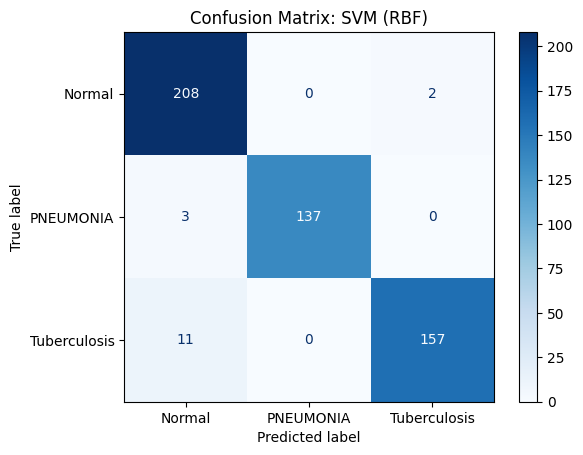


Training and evaluating: Random Forest
Cross-validation accuracy: 0.9551 ± 0.0079
Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.99      0.94       210
   PNEUMONIA       0.99      0.97      0.98       140
Tuberculosis       0.98      0.87      0.92       168

    accuracy                           0.95       518
   macro avg       0.96      0.94      0.95       518
weighted avg       0.95      0.95      0.95       518



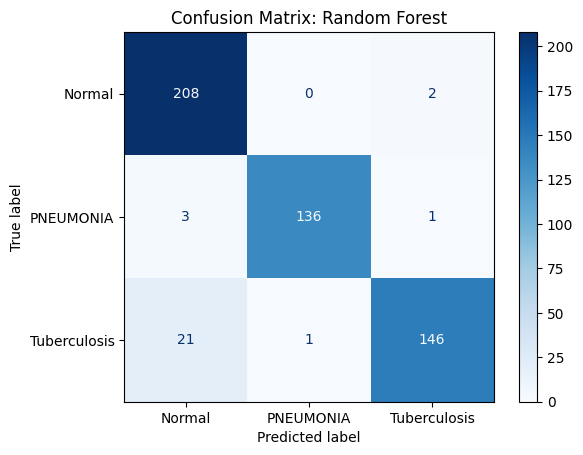


Training and evaluating: Logistic Regression
Cross-validation accuracy: 0.9773 ± 0.0083
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96       210
   PNEUMONIA       1.00      0.98      0.99       140
Tuberculosis       0.98      0.93      0.96       168

    accuracy                           0.97       518
   macro avg       0.97      0.97      0.97       518
weighted avg       0.97      0.97      0.97       518



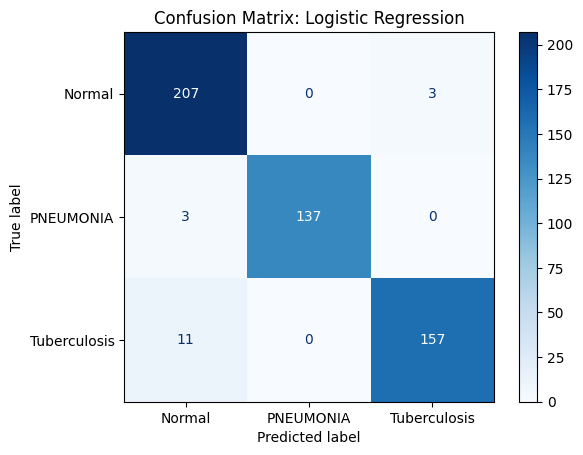


Training and evaluating: KNN
Cross-validation accuracy: 0.9609 ± 0.0123
Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95       210
   PNEUMONIA       0.99      0.99      0.99       140
Tuberculosis       1.00      0.89      0.94       168

    accuracy                           0.96       518
   macro avg       0.97      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



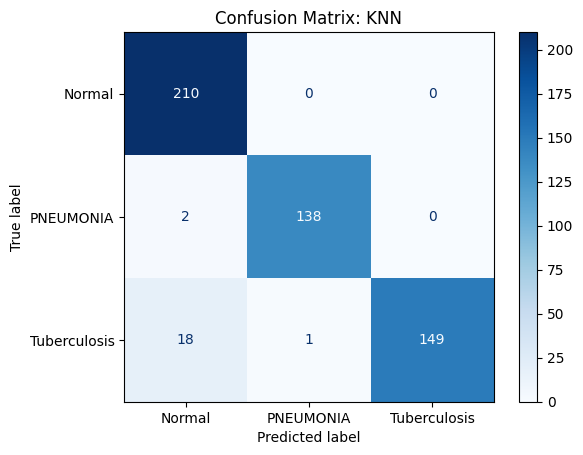

In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- Step 1: Feature Extraction ---
data_dir = 'ChestXrayProject/split_dataset/train'
categories = ['Normal', 'PNEUMONIA', 'Tuberculosis']
IMG_SIZE = 224

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def extract_features(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img.astype(np.float32))
    img = np.expand_dims(img, axis=0)
    features = model.predict(img, verbose=0)
    return features.flatten()

X, y = [], []

# Gather all image paths with labels
image_label_pairs = []
for category in categories:
    folder = os.path.join(data_dir, category)
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder, file)
            image_label_pairs.append((path, category))

# Unified progress bar
print("Extracting features...")
for path, category in tqdm(image_label_pairs, desc="Processing all images", unit="img"):
    features = extract_features(path, model)
    X.append(features)
    y.append(category)

X = np.array(X)
y = np.array(y)

# Save features for future use
os.makedirs('ChestXrayProject/features', exist_ok=True)
np.save('ChestXrayProject/features/X_features.npy', X)
np.save('ChestXrayProject/features/y_labels.npy', y)

# --- Step 2: Classification and Comparison ---
print("\nLoading features and labels...")
X = np.load('ChestXrayProject/features/X_features.npy')
y = np.load('ChestXrayProject/features/y_labels.npy')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Classifiers to compare
classifiers = {
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}

# Evaluation
for name, clf in classifiers.items():
    print(f"\nTraining and evaluating: {name}")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()